## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/solubility/solub_klek_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_klek_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_klek_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train = df_train_all['solubility']

X_test = df_test.loc[:, df_test.columns != 'solubility']
y_test = df_test['solubility']

In [5]:
X_train.shape, y_train.shape

((1410, 4860), (1410,))

In [6]:
X_test.shape, y_test.shape

((353, 4860), (353,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP18,KRFP20,KRFP25,KRFP27,...,KRFP4820,KRFP4823,KRFP4826,KRFP4827,KRFP4829,KRFP4833,KRFP4835,KRFP4843,KRFP4853,KRFP4856
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,1,0,0,1,0,1,0,1,0,0,...,0,1,1,0,1,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_test

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP18,KRFP20,KRFP25,KRFP27,...,KRFP4820,KRFP4823,KRFP4826,KRFP4827,KRFP4829,KRFP4833,KRFP4835,KRFP4843,KRFP4853,KRFP4856
0,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# write

with open('../../klek_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['solubility'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [9]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [11]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'svd', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 0.6650987204151657
MSE: 0.6681744962957198
RMSE: 0.8174194127225752
R2 Square 0.2700787849454016 

Base model:
MAE: 0.6952513863856373
MSE: 0.693704551405145
RMSE: 0.8328892791993093
R2 Square 0.24218947017928538 

Train set:
Tuned model:
MAE: 0.5564640529590087
MSE: 0.47095792591607727
RMSE: 0.6862637436992263
R2 Square 0.4974459457245767 

Base model:
MAE: 0.6430811723696013
MSE: 0.6061745715205926
RMSE: 0.7785721363628374
R2 Square 0.35315774137618794 



In [12]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [20]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8, 12],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 12, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 0.675360109860994
MSE: 0.6741515818835285
RMSE: 0.8210673430867461
R2 Square 0.26354935049538064 

Base model:
MAE: 0.6685313695967499
MSE: 0.6668536865710751
RMSE: 0.8166110987312597
R2 Square 0.27152165210721846 

Train set:
Tuned model:
MAE: 0.4762531724305898
MSE: 0.34135718286791766
RMSE: 0.5842578051407766
R2 Square 0.635741481847619 

Base model:
MAE: 0.45432646512354397
MSE: 0.3131728029157494
RMSE: 0.5596184440453597
R2 Square 0.665816725585475 



In [10]:
params = {'max_depth': 12, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.675360109860994
MSE: 0.6741515818835285
RMSE: 0.8210673430867461
R2 Square 0.26354935049538064 

Train set:
MAE: 0.4762531724305898
MSE: 0.34135718286791766
RMSE: 0.5842578051407766
R2 Square 0.635741481847619 



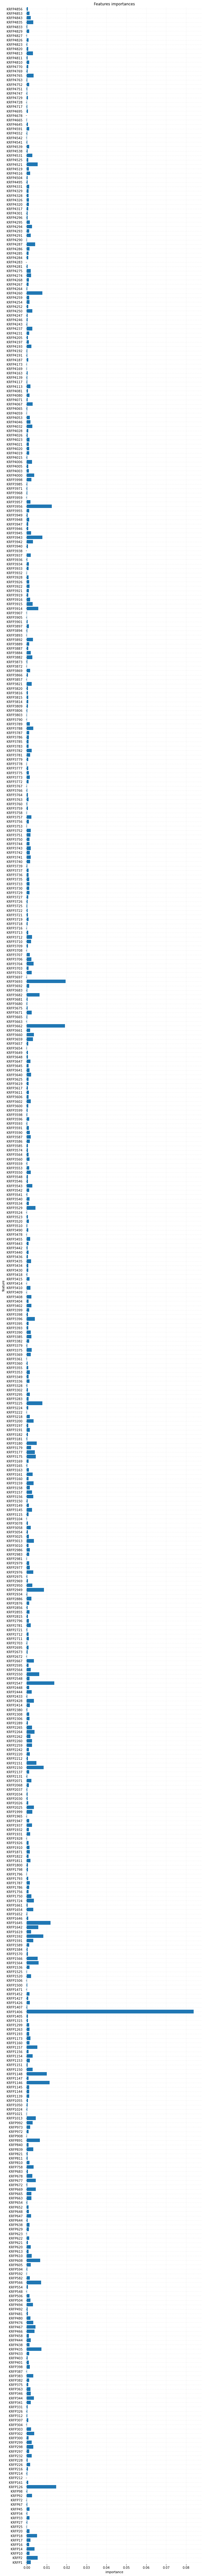

In [22]:
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [23]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [33]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [75, 85, 95],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}


grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 75, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.6638745585500808
MSE: 0.6573529066843912
RMSE: 0.8107730303139042
R2 Square 0.2819004092092935 

Base model:
MAE: 0.6642379373317144
MSE: 0.7038916519449213
RMSE: 0.8389825099159823
R2 Square 0.2310609687996309 

Train set:
Tuned model:
MAE: 0.5459863592384293
MSE: 0.4486361674715123
RMSE: 0.6698030811152725
R2 Square 0.5212652501413193 

Base model:
MAE: 0.22422589600399914
MSE: 0.08797985980383902
RMSE: 0.29661399124761295
R2 Square 0.9061176533912256 



In [34]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 75, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.6638745585500808
MSE: 0.6573529066843912
RMSE: 0.8107730303139042
R2 Square 0.2819004092092935 

Train set:
MAE: 0.5459863592384293
MSE: 0.4486361674715123
RMSE: 0.6698030811152725
R2 Square 0.5212652501413193 



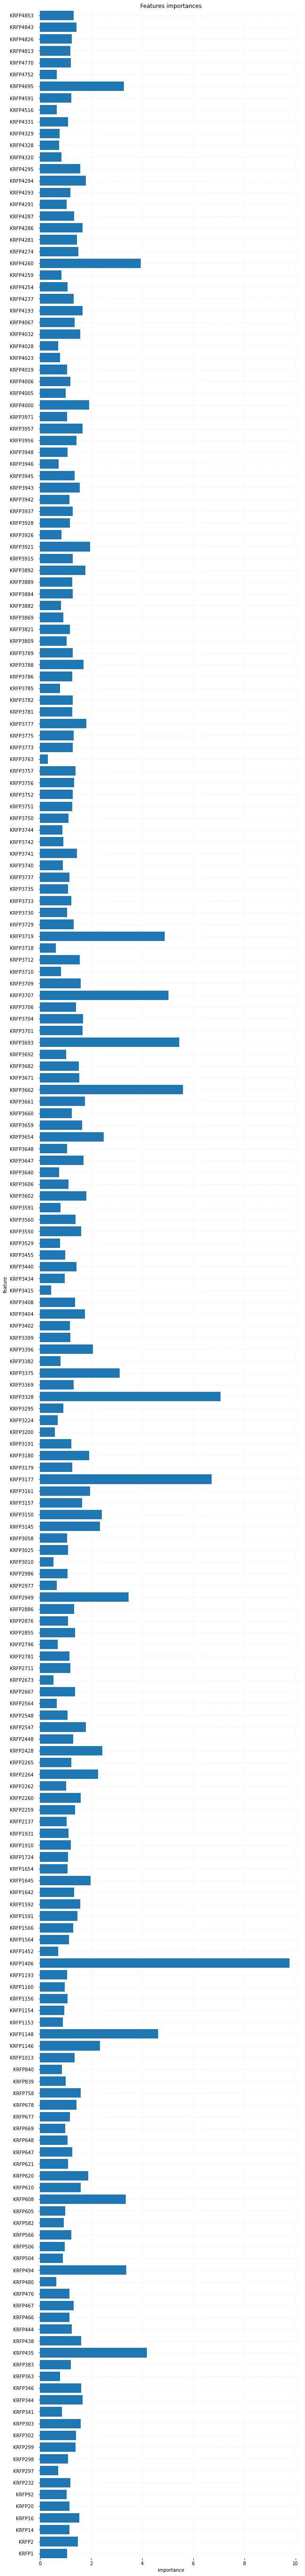

In [36]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [37]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549
2,XGBoost,0.663875,0.657353,0.810773,0.281900


## 5.4. LightGBM

Better results - third model.

In [50]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 1500, 3000],
    'min_child_samples': [75, 85, 95, 110],
    'reg_alpha': [1.7, 2.3, 2.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.35],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 75, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 0.6551287759572559
MSE: 0.6466975570863681
RMSE: 0.8041750786280113
R2 Square 0.2935404310427193 

Base model:
MAE: 0.64370439500519
MSE: 0.6503078909490316
RMSE: 0.8064166980842049
R2 Square 0.2895964623722632 

Train set:
Tuned model:
MAE: 0.5239043044262667
MSE: 0.4163633702623256
RMSE: 0.6452622492152518
R2 Square 0.5557031992399304 

Base model:
MAE: 0.3319779447027157
MSE: 0.17339812038465546
RMSE: 0.4164109993559914
R2 Square 0.8149687613101667 



In [51]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 75, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.6558537636516706
MSE: 0.6463900945885218
RMSE: 0.8039838895080683
R2 Square 0.2938763064783366 

Train set:
MAE: 0.5235710662516952
MSE: 0.41474288136857995
RMSE: 0.6440053426553074
R2 Square 0.5574324052234079 



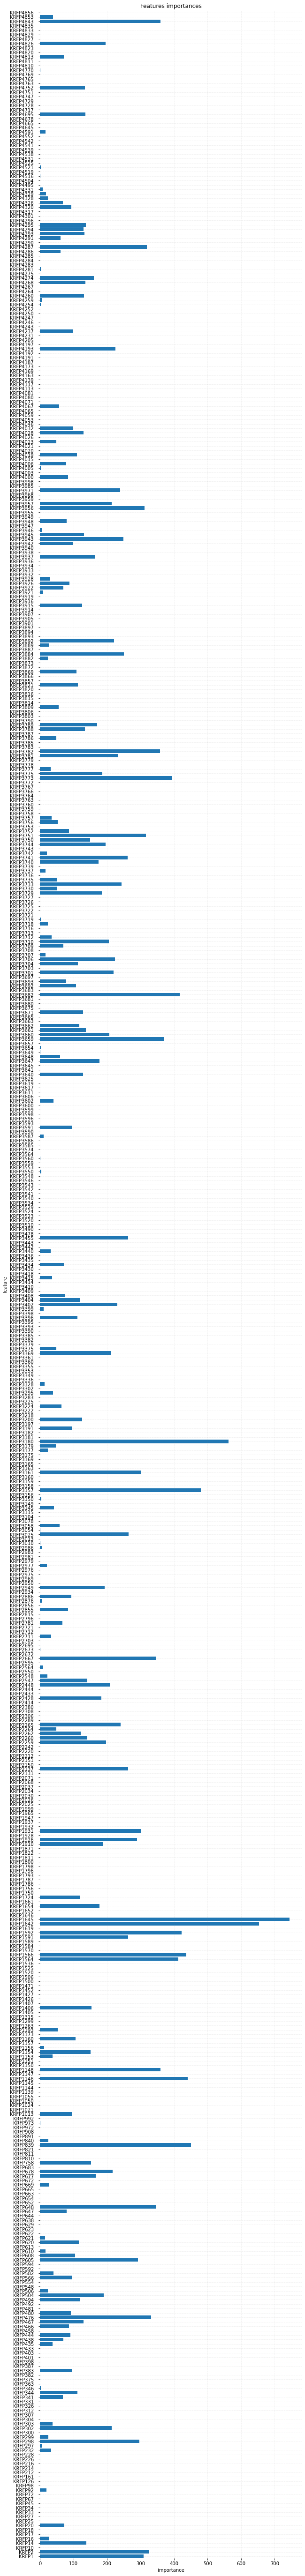

In [52]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [53]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549
2,XGBoost,0.663875,0.657353,0.810773,0.281900
3,LightGBM,0.655854,0.646390,0.803984,0.293876


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [59]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [2, 3, 4],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20} 

Test set:
Tuned model:
MAE: 0.6751460568899933
MSE: 0.6722674889774901
RMSE: 0.8199191966148189
R2 Square 0.2656075544389246 

Base model:
MAE: 0.6437043934759815
MSE: 0.6503078872103818
RMSE: 0.8064166957661416
R2 Square 0.2895964664564057 

Train set:
Tuned model:
MAE: 0.5710391113706729
MSE: 0.4891204359264488
RMSE: 0.6993714577579276
R2 Square 0.4780649298434325 

Base model:
MAE: 0.33197794296876615
MSE: 0.17339811931866767
RMSE: 0.41641099807602067
R2 Square 0.8149687624476706 



In [60]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.6751460568899933
MSE: 0.6722674889774901
RMSE: 0.8199191966148189
R2 Square 0.2656075544389246 

Train set:
MAE: 0.5710391113706729
MSE: 0.4891204359264488
RMSE: 0.6993714577579276
R2 Square 0.4780649298434325 



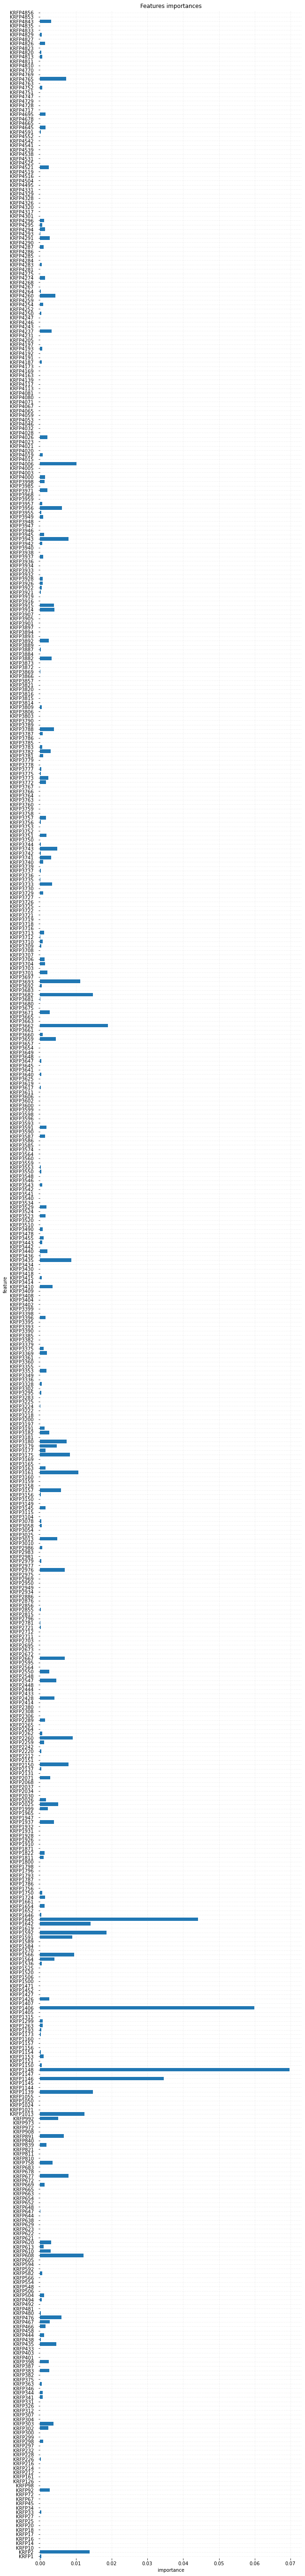

In [61]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [62]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549
2,XGBoost,0.663875,0.657353,0.810773,0.281900
3,LightGBM,0.655854,0.646390,0.803984,0.293876
4,HistGradient Boosting Regressor,0.675146,0.672267,0.819919,0.265608


## 5.6. Support Vector Regression

Better results - fifth model.

In [70]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [5.0, 10.0, 15.0],
    'epsilon': [0.9, 1.2, 1,7, 2,7],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 5.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.7019261756197347
MSE: 0.6954068610366789
RMSE: 0.8339105833581194
R2 Square 0.24032984829677262 

Base model:
MAE: 0.6500205743204889
MSE: 0.6511061244742696
RMSE: 0.8069114725137261
R2 Square 0.2887244632345094 

Train set:
Tuned model:
MAE: 0.5785859618284006
MSE: 0.42944639634519904
RMSE: 0.6553215976489704
R2 Square 0.5417424451293589 

Base model:
MAE: 0.4129580564250868
MSE: 0.3247977369356032
RMSE: 0.5699102884977628
R2 Square 0.6534118855756206 



In [71]:
params = {'C': 5.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.7019261756197347
MSE: 0.6954068610366789
RMSE: 0.8339105833581194
R2 Square 0.24032984829677262 

Train set:
MAE: 0.5785859618284006
MSE: 0.42944639634519904
RMSE: 0.6553215976489704
R2 Square 0.5417424451293589 



In [90]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [72]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549
2,XGBoost,0.663875,0.657353,0.810773,0.281900
3,LightGBM,0.655854,0.646390,0.803984,0.293876
4,HistGradient Boosting Regressor,0.675146,0.672267,0.819919,0.265608
5,Support Vector Regression,0.701926,0.695407,0.833911,0.240330


### Save models

In [11]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''
pickle.dump(rf_best, open('../../models/solub_pubchem_rf_model.pkl', 'wb'))

## 5.7. Stacking models

### Averaging base models

In [73]:
def average_predictions(X):
    return ((0.20 * rf_best.predict(X)) + \
            (0.25 * xgbr_best.predict(X)) + \
            (0.25 * lgbm_best.predict(X)) + \
            (0.20 * hist_best.predict(X)) + \
            (0.10 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.6628562515564437
MSE: 0.6446252866725529
RMSE: 0.8028855999907788
R2 Square 0.295804202178492 

Train set:
MAE: 0.5254401488048328
MSE: 0.4047628101115553
RMSE: 0.6362097217989955
R2 Square 0.5680820301605389 



In [74]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549
2,XGBoost,0.663875,0.657353,0.810773,0.281900
3,LightGBM,0.655854,0.646390,0.803984,0.293876
4,HistGradient Boosting Regressor,0.675146,0.672267,0.819919,0.265608
5,Support Vector Regression,0.701926,0.695407,0.833911,0.240330
6,Averaging base models,0.662856,0.644625,0.802886,0.295804


### Averaging base models with Meta-model

In [75]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [76]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.552264,4.712354,4.741261,4.667402,4.702973
1,4.531067,4.207748,4.041548,4.244159,4.509029
2,4.148719,4.179294,4.075339,4.190160,4.495790
3,4.346333,4.682994,4.642641,4.281064,4.552609
4,4.880005,4.760011,4.867190,4.751942,4.711927
...,...,...,...,...,...
1405,5.198714,5.479468,5.464210,5.489884,5.424673
1406,3.680777,3.300380,3.178764,3.405158,3.933691
1407,4.550521,4.154878,3.974416,4.406079,4.459008
1408,4.905933,4.636701,4.633713,4.441100,4.924112


In [77]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.6779644238320581
MSE: 0.7040072693161885
RMSE: 0.8390514104130857
R2 Square 0.23093466710361488 

Train set:
MAE: 0.3690150897588297
MSE: 0.20136964777860525
RMSE: 0.44874229550890926
R2 Square 0.7851206502103008 



In [78]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549
2,XGBoost,0.663875,0.657353,0.810773,0.281900
3,LightGBM,0.655854,0.646390,0.803984,0.293876
4,HistGradient Boosting Regressor,0.675146,0.672267,0.819919,0.265608
5,Support Vector Regression,0.701926,0.695407,0.833911,0.240330
6,Averaging base models,0.662856,0.644625,0.802886,0.295804
7,Base models + Meta-model,0.677964,0.704007,0.839051,0.230935


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [79]:
params_rf = {'max_depth': 12, 'n_estimators': 2000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 75, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 75, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}   

params_svr = {'C': 5.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'} 

In [80]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.7318899034154324
Model1 R2: 0.22455417212276307
Model2 MSE: 0.7639515481779412
Model2 R2: 0.19058448822638963
Model3 MSE: 0.7622208614687854
Model3 R2: 0.19241817083591128
Model4 MSE: 0.7684472546835638
Model4 R2: 0.18582123512387105
Model5 MSE: 0.7689560925586929
Model5 R2: 0.18528211550288232
Average MSE = 0.7590931320608831
Average R2 = 0.19573203636236347
-------------- fold 2 --------------
Model1 MSE: 0.6327785338067388
Model1 R2: 0.290282697481677
Model2 MSE: 0.6420756454685447
Model2 R2: 0.2798551613733744
Model3 MSE: 0.637135850266246
Model3 R2: 0.285395580238214
Model4 MSE: 0.6313503424502879
Model4 R2: 0.2918845408800024
Model5 MSE: 0.6625928202522737
Model5 R2: 0.25684332837833723
Average MSE = 0.6411866384488183
Average R2 = 0.280852261670321
-------------- fold 3 --------------
Model1 MSE: 0.7084409231223713
Model1 R2: 0.27992884898139525
Model2 MSE: 0.7189741909149682
Model2 R2: 0.2692226602000164
Model3 MSE: 0.696694260

In [81]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [82]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [83]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.519267,4.493525,4.416137,4.835813,4.713904
1,4.067086,3.972413,3.765792,3.880525,3.871603
2,4.229003,4.128459,3.988314,4.270409,4.455642
3,4.453722,4.714796,4.824861,4.471127,4.394907
4,4.389373,4.525196,4.571022,4.785677,4.596995
...,...,...,...,...,...
1405,5.292274,5.396117,5.510290,5.444099,5.380697
1406,3.709221,3.327411,3.180737,3.350999,4.026287
1407,4.583516,4.292196,4.070959,4.562381,4.600580
1408,4.096943,4.178586,4.421985,4.036830,4.830864


In [84]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.152001,4.429327,4.534264,4.181264,4.328714
1,4.141663,4.055114,4.057046,4.265649,4.223648
2,5.058790,5.116988,5.145664,5.030673,4.864068
3,4.582661,4.373419,4.482639,4.672880,4.770565
4,4.182416,4.098164,3.953220,3.871354,4.232156
...,...,...,...,...,...
348,4.370095,4.124541,3.877825,4.358193,4.137757
349,5.429497,5.536863,5.574347,5.447698,5.449286
350,3.830054,4.108935,4.020138,4.084768,4.264242
351,4.437811,4.142428,4.179409,4.253505,4.198811


In [85]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.6633531364204703
MSE: 0.642204986199967
RMSE: 0.8013769314124078
R2 Square 0.2984481652024342 

Train set:
MAE: 0.6661082797757304
MSE: 0.6760286407892304
RMSE: 0.8222096087915967
R2 Square 0.27861722769801733 



In [86]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.665099,0.668174,0.817419,0.270079
1,Random Forest Regressor,0.675360,0.674152,0.821067,0.263549
2,XGBoost,0.663875,0.657353,0.810773,0.281900
3,LightGBM,0.655854,0.646390,0.803984,0.293876
4,HistGradient Boosting Regressor,0.675146,0.672267,0.819919,0.265608
5,Support Vector Regression,0.701926,0.695407,0.833911,0.240330
6,Averaging base models,0.662856,0.644625,0.802886,0.295804
7,Base models + Meta-model,0.677964,0.704007,0.839051,0.230935
8,Base models + Meta-model + cv,0.663353,0.642205,0.801377,0.298448
